# TASK #2: IMPORT LIBRARIES AND DATASETS

In [15]:
!pip install keras_preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score,RocCurveDisplay, precision_score, f1_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [16]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/colab proyects/Tumor_Segmentation_MRI


/content/drive/MyDrive/colab proyects/Tumor_Segmentation_MRI


In [18]:
brain_df=pd.read_csv('route_label.csv',index_col=0)

# DATA

In [19]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.to_csv("segmentation_routes_labels.csv")
brain_df_mask.shape

(1366, 3)

In [20]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

brain_df_mask_train, brain_df_mask_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
brain_df_mask_test, brain_df_mask_val = train_test_split(brain_df_mask_val, test_size=0.5,random_state=42)

In [21]:
brain_df_mask_train.to_csv("segmentation_train.csv")
brain_df_mask_test.to_csv("segmentation_test.csv")
brain_df_mask_val.to_csv("segmentation_validation.csv")

In [22]:
BATCH_SIZE = 16

In [23]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [44]:
def train_generator_fn():
  image_generator = datagen.flow_from_dataframe(
      brain_df_mask_train,
      x_col='image_path',
      class_mode = None,
      color_mode = "rgb",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  mask_generator = datagen.flow_from_dataframe(
      brain_df_mask_train,
      x_col = "mask_path",
      class_mode = None,
      color_mode ="grayscale",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  train_gen_zipped = zip(image_generator, mask_generator)

  while True:
      for (img, mask) in train_gen_zipped:
          img = img.astype(np.float32)
          mask = mask.astype(np.float32)
          yield (img, mask)

training_generator = train_generator_fn()


def val_generator_fn():
  image_generator_val = datagen.flow_from_dataframe(
      brain_df_mask_val,
      x_col='image_path',
      class_mode = None,
      color_mode = "rgb",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  mask_generator_val = datagen.flow_from_dataframe(
      brain_df_mask_val,
      x_col = "mask_path",
      class_mode = None,
      color_mode ="grayscale",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  val_gen_zipped = zip(image_generator_val, mask_generator_val)

  while True:
      for (img, mask) in val_gen_zipped:
          img = img.astype(np.float32)
          mask = mask.astype(np.float32)
          yield (img, mask)

validation_generator = val_generator_fn()

test_datagen=ImageDataGenerator(rescale=1./255.)

def test_generator_fn():
  image_generator_test = test_datagen.flow_from_dataframe(
      brain_df_mask_test,
      x_col='image_path',
      class_mode = None,
      color_mode = "rgb",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  mask_generator_test = test_datagen.flow_from_dataframe(
      brain_df_mask_test,
      x_col = "mask_path",
      class_mode = None,
      color_mode ="grayscale",
      target_size = (256,256),
      batch_size = BATCH_SIZE)

  test_gen_zipped = zip(image_generator_test, mask_generator_test)

  while True:
      for (img, mask) in test_gen_zipped:
          img = img.astype(np.float32)
          mask = mask.astype(np.float32)
          yield (img, mask)

  test_generator= test_generator_fn()


In [25]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [26]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [27]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [28]:
model_seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [29]:
LEARNING_RATE = 1e-4
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

model_seg.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_coef, 'accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("segmentation_ResUNet.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

steps_per_epoch_calc = len(brain_df_mask_train) // BATCH_SIZE
validation_steps_calc = len(brain_df_mask_val) // BATCH_SIZE

history = model_seg.fit(
    training_generator, # Use the direct Python generator
    steps_per_epoch=steps_per_epoch_calc,
    epochs=100,
    validation_data=validation_generator, # Use the direct Python generator
    validation_steps=validation_steps_calc,
    callbacks=callbacks)


Found 1092 validated image filenames.
Found 1092 validated image filenames.
Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5108 - dice_coef: 0.0602 - iou_coef: 0.0311 - loss: 1.7735 Found 137 validated image filenames.
Found 137 validated image filenames.

Epoch 1: val_loss improved from inf to 1.58902, saving model to segmentation_ResUNet.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 1690s 25s/step - accuracy: 0.5133 - dice_coef: 0.0603 - iou_coef: 0.0311 - loss: 1.7708 - val_accuracy: 0.6351 - val_dice_coef: 0.0635 - val_iou_coef: 0.0328 - val_loss: 1.5890 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8983 - dice_coef: 0.0678 - iou_coef: 0.0351 - loss: 1.3280
Epoch 2: val_loss improved from 1.58902 to 1.45865, saving model to segmentation_ResUNet.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 55s 502ms/step - accuracy: 0.8986 - dice_coef: 0.0678 - iou_coef: 0.0351 - loss: 1.3276 - val_accuracy: 0.8996 - val_dice_coef: 0.0595 - val_iou_coef: 0.0

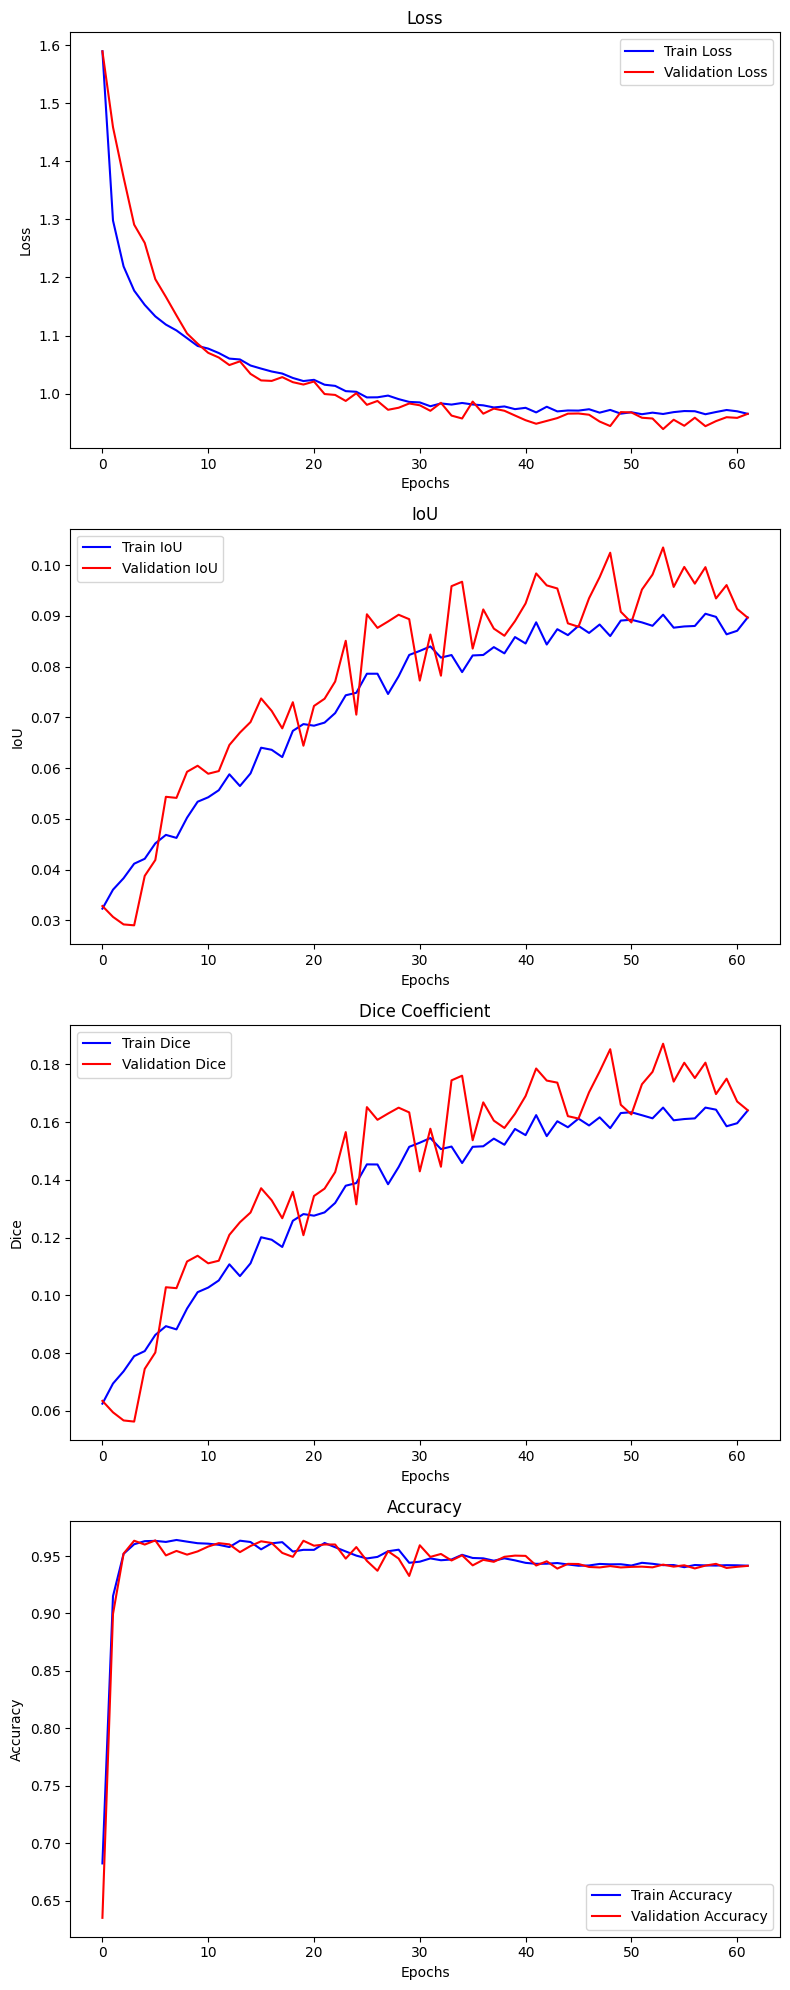

In [46]:
# Evaluation Visualization
plt.figure(figsize=(8, 20))

# --- Loss ---
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(4, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Validation IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(4, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Validation Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.subplot(4, 1, 4)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
loaded_model_seg=load_model("segmentation_ResUNet4.keras", custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})

In [45]:
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) // BATCH_SIZE)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 256, 256, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
print(f" Test Loss: {prediction_seg[0]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Accuracy: {prediction_seg[3]:.4f}")

In [41]:
loaded_model_seg=load_model("segmentation_ResUNet.keras", custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) // BATCH_SIZE)
print(f" Test Loss: {prediction_seg[0]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Accuracy: {prediction_seg[3]:.4f}")

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 256, 256, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
def visualize_predictions(model, X_test, y_test, num_per_class=4):

    # Flatten masks to detect presence of tumor (any pixel > 0)
    tumor_indices = [i for i in range(len(y_test)) if np.any(y_test[i] > 0)]
    non_tumor_indices = [i for i in range(len(y_test)) if not np.any(y_test[i] > 0)]

    # Ensure enough samples exist in both categories
    tumor_indices = random.sample(tumor_indices, min(num_per_class, len(tumor_indices)))
    non_tumor_indices = random.sample(non_tumor_indices, min(num_per_class, len(non_tumor_indices)))

    selected_indices = tumor_indices + non_tumor_indices
    total_samples = len(selected_indices)

    plt.figure(figsize=(12, total_samples * 2.5))

    for i, idx in enumerate(selected_indices):
        image = X_test[idx]
        true_mask = y_test[idx]

        # Predict mask
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Titles
        label = "Tumor" if np.any(true_mask > 0) else "Non-Tumor"

        # Original MRI
        plt.subplot(total_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"{label} - MRI")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(total_samples, 3, i*3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(total_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(model, X_test, y_test, num_per_class=4)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

MINI CHALLENGE:
- Plot 30 images along with their corresponding mask
- Visually verify that model predictions made sense

# EXCELLENT JOB! NOW YOU KNOW HOW TO APPLY AI TO DETECT AND LOCALIZE BRAIN TUMORS. THIS IS A GREAT ACHIEVEMENT IN HEALTHCARE.

# MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #1

In [ ]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

MINI CHALLENGE #2

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

MINI CHALLENGE #3:

- An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set.
- Solution (great article by Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI CHALLENGE #4:
- Negative Transfer occurs when transfer learning negatively affect the model. This occurs when the features of old and new tasks are not related.  
- Transfer bounds: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness.

MINI CHALLENGE #5:

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Total parameters (original model) = 25,685,634
# Total parameters (New model with added dense and dropout layers) = 25,751,426

MINI CHALLENGE #6:

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

MINI CHALLENGE #7:


- Total params: 1,210,513

MINI CHALLENGE #8:

In [ ]:
count = 0
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30: